In [1]:
from util import *

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn
Connected oraDW_ANALYTICS - conn_aly


In [2]:
query = """WITH 
T0 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_CUST_STT_CHG_01102023),
T1 AS (
    SELECT * FROM CINS_REACTIVATED_CASA_SCORE_01112023),
T2 AS (
    SELECT *
        FROM (SELECT T0.*, T1.SCORE, T1.RANK
        FROM T0 INNER JOIN T1 ON T0.CUSTOMER_CDE = T1.CUSTOMER_CDE
        WHERE REACTIVATED IS NOT NULL
        AND CUST_STT_LAG <= 1
        ORDER BY SCORE DESC)
    WHERE ROWNUM <= 100000),
T21 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUST_PRODUCT_LOC_FCT
    WHERE SD_TKTT = 1 AND PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')),
T3 AS (
    SELECT T21.*, T2.SCORE, T2.CUST_STT, T2.CUST_STT_LAG, T2.CUST_STT_CHG, T2.REACTIVATED
    FROM T21 
    INNER JOIN T2 ON T21.CUSTOMER_CDE = T2.CUSTOMER_CDE),
T4 AS (
    SELECT * FROM DW_ANALYTICS.DW_ORG_LOCATION_DIM),
T5 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_FULL_DIM),
T6 AS (
    SELECT * FROM DW_ANALYTICS.DW_DEPOSIT_FCT),
T7 AS (
    SELECT * FROM DW_ANALYTICS.DW_LOAN_FCT),
T8 AS (
    SELECT * FROM DW_ANALYTICS.DW_SBVCODE_DIM),
T9 AS (
    SELECT * FROM DW_ANALYTICS.DW_CUSTOMER_DIM
    WHERE ACTIVE = 1),
T10 AS (
    SELECT * FROM CINS_FEATURE_STORE_REACTIVATED_01112023
    WHERE FTR_NM='CASA_DAY_SINCE_LAST_TXN_CT_36M'),
D1 AS (
    SELECT 
    T4.AREA_NAME, T5.SUB_BRANCH_CDE, T4.SUB_BRANCH_NAME, 
    T5.CUSTOMER_CDE, T5.FULL_NAME, T5.EMAIL, T5.MOBILE_PHONE, 
    T3.CUST_TYPE, T3.CUST_STATUS, T3.CUST_OPEN_DT,
    T3.TKTT, T3.TK, T3.VAY, T3.BH, T3.PAY, T3.IB, T3.MB, T3.SP_KHAC, 
    T3.LASTEST_TRANS_DT, T10.FTR_VAL AS CASA_DAY_SINCE_LAST_TXN,
    T9.DAO_CDE,
    T1.SCORE, T1.RANK, T3.REACTIVATED
    FROM T5
    INNER JOIN T3 ON T5.CUSTOMER_CDE = T3.CUSTOMER_CDE
    INNER JOIN T4 ON T5.SUB_BRANCH_CDE = T4.SUB_BRANCH_CDE
    INNER JOIN T1 ON T5.CUSTOMER_CDE = T1.CUSTOMER_CDE
    INNER JOIN T9 ON T5.CUSTOMER_CDE = T9.CUSTOMER_CDE
    INNER JOIN T10 ON T5.CUSTOMER_CDE = T10.CUSTOMER_CDE),
D2 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(ACTUAL_BAL_LCL) AS TOTAL_BAL
    FROM T1 
    LEFT JOIN T6 ON T1.CUSTOMER_CDE = T6.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T6.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'DP' AND T6.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D3 AS (
    SELECT 
    T1.CUSTOMER_CDE, SUM(OS_AMT_LCL) AS TOTAL_LOAN
    FROM T1 
    LEFT JOIN T7 ON T1.CUSTOMER_CDE = T7.CUSTOMER_CDE
    INNER JOIN T8 ON T8.SBVCODE_LVL_3 = T7.SBVCODE_LVL_3
    WHERE T8.APPLICATION = 'LN' AND T7.PROCESS_DT = TO_DATE('31-10-2023', 'DD-MM-YY')
    GROUP BY T1.CUSTOMER_CDE),
D4 AS (
    SELECT 
    D1.AREA_NAME, D1.SUB_BRANCH_CDE, D1.SUB_BRANCH_NAME, 
    D1.CUSTOMER_CDE, D1.FULL_NAME, D1.EMAIL, D1.MOBILE_PHONE, 
    D1.CUST_TYPE, D1.CUST_STATUS, D1.CUST_OPEN_DT,
    D1.TKTT, D1.TK, D1.VAY, D1.BH, D1.PAY, D1.IB, D1.MB, D1.SP_KHAC, 
    NVL(D2.TOTAL_BAL, 0) AS TOTAL_BAL, 
    NVL(D3.TOTAL_LOAN, 0) AS TOTAL_LOAN,
    D1.LASTEST_TRANS_DT, 
    CASE WHEN D1.CASA_DAY_SINCE_LAST_TXN IS NULL THEN NULL ELSE ROUND(D1.CASA_DAY_SINCE_LAST_TXN / 30) END AS MONTH_TYPE,
    D1.DAO_CDE,
    D1.CASA_DAY_SINCE_LAST_TXN,
    D1.SCORE, D1.RANK, D1.REACTIVATED
    FROM D1 
    LEFT JOIN D2 ON D1.CUSTOMER_CDE = D2.CUSTOMER_CDE
    LEFT JOIN D3 ON D1.CUSTOMER_CDE = D3.CUSTOMER_CDE)
SELECT *
FROM D4
"""

In [3]:
portfolio = download_or_reload('data/PORTFOLIO_11', query, update=False)

Len 102223


In [14]:
portfolio['CASA_DAY_SINCE_LAST_TXN'] = portfolio['CASA_DAY_SINCE_LAST_TXN'].astype(int)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102223 entries, 0 to 102222
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   AREA_NAME                102223 non-null  object        
 1   SUB_BRANCH_CDE           102223 non-null  object        
 2   SUB_BRANCH_NAME          102223 non-null  object        
 3   CUSTOMER_CDE             102223 non-null  object        
 4   FULL_NAME                102223 non-null  object        
 5   EMAIL                    102223 non-null  object        
 6   MOBILE_PHONE             102223 non-null  object        
 7   CUST_TYPE                102223 non-null  object        
 8   CUST_STATUS              102223 non-null  object        
 9   CUST_OPEN_DT             102223 non-null  datetime64[ns]
 10  TKTT                     102223 non-null  int64         
 11  TK                       102223 non-null  int64         
 12  VAY             

In [5]:
portfolio.sort_values(by='RANK')

,AREA_NAME,SUB_BRANCH_CDE,SUB_BRANCH_NAME,CUSTOMER_CDE,FULL_NAME,EMAIL,MOBILE_PHONE,CUST_TYPE,CUST_STATUS,CUST_OPEN_DT,...,SP_KHAC,TOTAL_BAL,TOTAL_LOAN,LASTEST_TRANS_DT,MONTH_TYPE,DAO_CDE,CASA_DAY_SINCE_LAST_TXN,SCORE,RANK,REACTIVATED
99705,KV DONG NAM BO,VN0011378,PGD LONG THANH-CN DNI,18445404,NGUYEGOCUF2QXSA,ABCxxxxxxx@SACOMBANK.COM,038xxxxxx04,CN,HOAT DONG,2023-09-28,...,0,50119.0,0,2023-11-01,0,33599,1,0.887594,2747,1
36307,KV DONG NAM BO,VN0012241,CN BA RIA - VUNG TAU,18440597,DO THENGMTYGSW8,ABCxxxxxxx@SACOMBANK.COM,093xxxxxx04,CN,HOAT DONG,2023-09-26,...,1,52006.0,2000000000,2023-11-01,0,63563,1,0.856832,4121,1
29839,KV DONG NAM BO,VN0011348,PGD TAN PHUOC KHANH,18445527,NGUYERTZWPBJYLE,tn2xxxxxxx@gmail.com,093xxxxxx97,CN,HOAT DONG,2023-09-28,...,0,0.0,0,2023-10-10,1,71289,22,0.853722,4295,1
29838,KV DONG NAM BO,VN0011348,PGD TAN PHUOC KHANH,18445527,NGUYERTZWPBJYLE,tn2xxxxxxx@gmail.com,093xxxxxx97,CN,NGU DONG,2023-09-28,...,0,0.0,0,2023-10-10,1,71289,22,0.853722,4295,1
74601,KV DONG NAM BO,VN0011378,PGD LONG THANH-CN DNI,18445615,HO THVPBEZCXX25,ABCxxxxxxx@SACOMBANK.COM,093xxxxxx20,CN,HOAT DONG,2023-09-28,...,0,126544.0,0,2023-11-01,0,33599,1,0.852556,4326,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44289,KV DONG NAM BO,VN0011379,PGD DONG HOA-CNDNI,6662819,TRAN AEDU7D8742,ABCxxxxxxx@SACOMBANK.COM,093xxxxxx52,CN,NGU DONG,2015-05-13,...,0,1500.0,0,NaT,37,61063,1095,0.031167,2186933,0
90159,KV DONG NAM BO,VN0011375,PGD TRANG BOM,6672243,NGUYE8LTO9GKFYV,linxxxxxxx@gmail.com,093xxxxxx97,CN,NGU DONG,2015-05-14,...,0,1500.0,0,NaT,37,25912,1095,0.031167,2186934,0
16180,KV DONG NAM BO,VN0011379,PGD DONG HOA-CNDNI,6644291,HUYNHQUFQO7KNRG,ABCxxxxxxx@SACOMBANK.COM,092xxxxxx78,CN,NGU DONG,2015-05-11,...,0,1500.0,0,NaT,37,61063,1095,0.031167,2186935,0
6691,HOI SO,VN0010001,HOI SO SACOMBANK,17031452,DUONGJ9MPCJW3CX,dunxxxxxxx@gmail.com,038xxxxxx04,CN,NGU DONG,2022-07-25,...,0,800.0,0,2022-09-27,13,309,400,0.031167,2186949,0


In [6]:
portfolio.groupby('REACTIVATED')[['TOTAL_LOAN', 'TOTAL_BAL']].describe()

TOTAL_LOAN                                                  \
                 count          mean           std  min  25%  50%  75%   
REACTIVATED                                                              
0              85443.0  0.000000e+00  0.000000e+00  0.0  0.0  0.0  0.0   
1              16780.0  8.876579e+06  1.447911e+08  0.0  0.0  0.0  0.0   

                          TOTAL_BAL                                           \
                      max     count          mean           std  min     25%   
REACTIVATED                                                                    
0            0.000000e+00   85443.0  1.212690e+03  5.018914e+04  0.0     0.0   
1            8.000000e+09   16780.0  4.470084e+06  9.218263e+07  0.0  1600.0   

                                             
                 50%      75%           max  
REACTIVATED                                  
0                0.0    856.0  8.810689e+06  
1            10700.5  96254.5  9.420902e+09

<Axes: xlabel='TOTAL_BAL', ylabel='Density'>

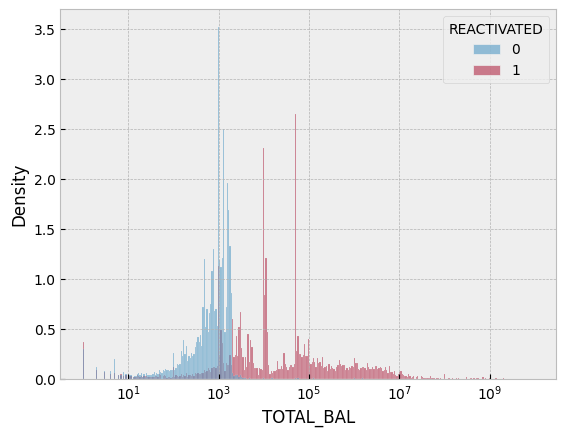

In [7]:
sns.histplot(portfolio, x='TOTAL_BAL', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False)

<Axes: xlabel='TOTAL_LOAN', ylabel='Density'>

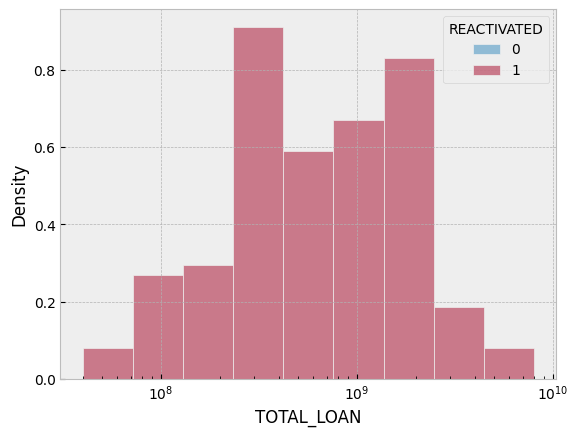

In [8]:
sns.histplot(portfolio, x='TOTAL_LOAN', hue='REACTIVATED', log_scale=True, stat='density', common_norm=False)

<Axes: xlabel='SCORE', ylabel='Density'>

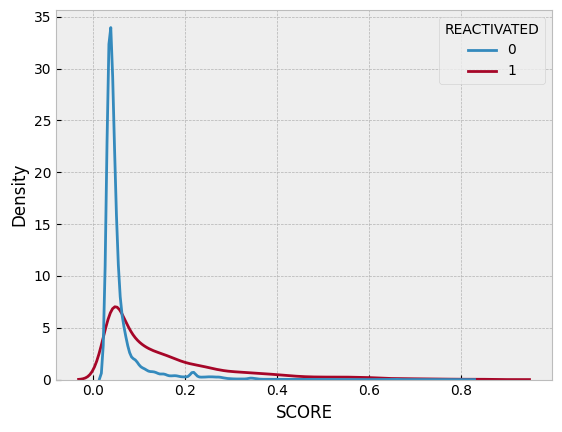

In [9]:
sns.kdeplot(portfolio, x='SCORE', hue='REACTIVATED', common_norm=False,)

<Axes: xlabel='SCORE', ylabel='Density'>

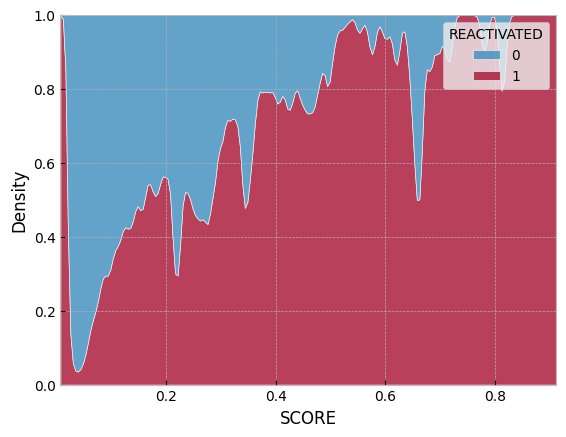

In [10]:
sns.kdeplot(portfolio, x='SCORE', hue='REACTIVATED', multiple='fill')

<Axes: xlabel='SCORE', ylabel='Density'>

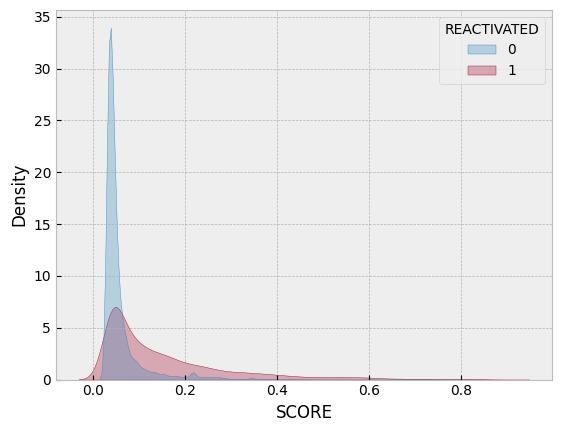

In [11]:
sns.kdeplot(portfolio, x='SCORE', hue='REACTIVATED', fill=True, common_norm=False, alpha=0.3, linewidth=0.3)

<Axes: xlabel='CASA_DAY_SINCE_LAST_TXN', ylabel='Density'>

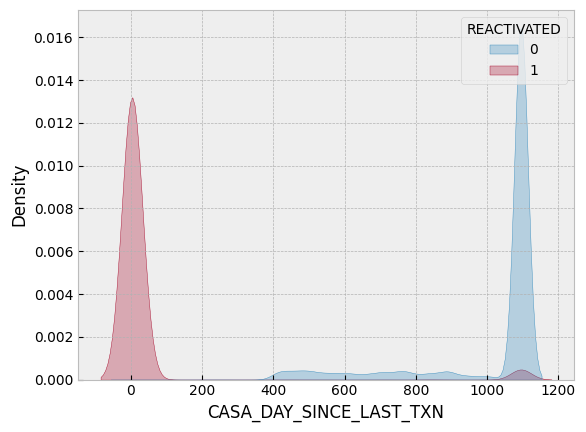

In [15]:
sns.kdeplot(portfolio, x='CASA_DAY_SINCE_LAST_TXN', hue='REACTIVATED', fill=True, common_norm=False, alpha=0.3, linewidth=0.3)

In [18]:
portfolio.groupby('REACTIVATED')['MONTH_TYPE'].agg(['min','max'])

,min,max
REACTIVATED,,
0,0,37
1,0,37


<Axes: xlabel='MONTH_TYPE', ylabel='Density'>

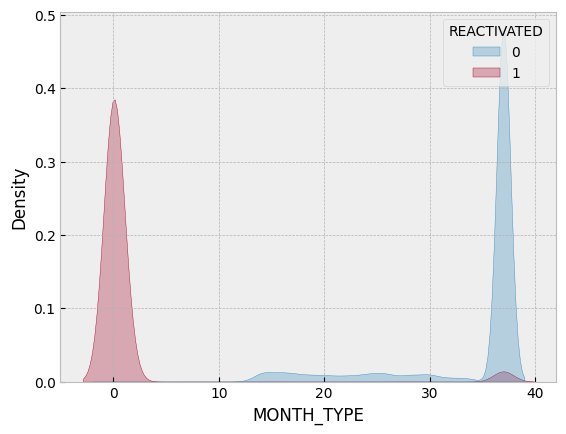

In [16]:
sns.kdeplot(portfolio, x='MONTH_TYPE', hue='REACTIVATED', fill=True, common_norm=False, alpha=0.3, linewidth=0.3)